# Predicting Boris Bike usage
### Markus Hauru, February 2020

Since 2010, Transport for London (TfL) has been operating its public bicycle sharing scheme. It was originally called Barclays Cycle Hire and is now officially known as Santander Cycles, but is more colloquially known as Boris Bikes, after then London mayor Boris Johnson. The system includes more than 10,000 bikes and hundreds of stations. With a credit card, one can go to a station, rent a bike for a time, and return it to any of the other stations in London. Transport for London makes public usage data of Boris Bikes since 2012, and in this notebook I study that data. The goal is to
* create a model for predicting the number of bikes leaving and arriving at each station, using both periodic and autoregressive features in the data, and possibly weather data,
* see whether the weather data is a useful predictor, by testing the hypothesis that it affects bike usage.

Weather data for London is kindly provided for free by America's [National Centers for Environmental Information](https://www.ncdc.noaa.gov/).

A quick shout out to a couple of other interesting analyses of the same bike data that I found, that take a more exploratory tone and focus on different aspects:
* [Anders Ohrn](https://medium.com/@AJOhrn/data-footprint-of-bike-sharing-in-london-be9e11425248) has, among other things, some cool animated maps of when and where bikes are used, and an analysis of how people favor short trips.
* [charlie1347](https://github.com/charlie1347/TfL_bikes) for instance divides stations into two categories based on whether they see incoming traffic in the morning and outgoing in the afternoon or the other way around, and looks at the effect London tube strikes had on bike usage.

In addition to hopefully giving some insight into Boris Bike usage, this project is also a vehicle for me to learn some machine learning and statistical modelling, and usage of relevant Python packages, such as scikit-learn and statsmodels.

In [2]:
import os
import pickle
import requests
import zipfile
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.api as sm
from sklearn import linear_model, svm, neighbors, tree
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
from pathlib import Path
from timeit import default_timer as timer
from IPython.display import set_matplotlib_formats
from urllib.parse import urlparse

try:
    import xlrd
except Exception as e:
    msg = (
        "Please install the package xlrd: `pip install --user xlrd`"
        "It's an optional requirement for pandas, and we'll be needing it."
    )
    print(msg)
    raise e

In [18]:
# For pretty and exportable matplotlib plots.
# If you are running this yourself and want interactivity,
# try `%matplotlib widget` instead.
set_matplotlib_formats("svg")
%matplotlib inline
# %matplotlib widget
# Set a consistent plotting style across the notebook using Seaborn.
sns.set_style("darkgrid")
sns.set_context("notebook")
# Make pandas cooperate with pyplot
pd.plotting.register_matplotlib_converters()

## Processing and cleaning the bike data

Before getting anywhere with it, we'll need to process the bike data quite a bit. The data comes in CSV files, each of which covers a period of time. Up first, we need to download the data from the TfL website. If you are running this code yourself, here's a script that does that. Be warned though, it's almost seven gigs of data. You can run it repeatedly, and it'll only download data that it doesn't have already.

In [4]:
bikefolder = "./data/bikes"

In [50]:
def download_file(datafolder, url, verbosity=0):
    """Download the data from the given URL into the datafolder, unless it's
    already there. Return path to downloaded file.
    """
    datafolder = Path(datafolder)
    datafolder.mkdir(parents=True, exist_ok=True)

    a = urlparse(url)
    filename = Path(os.path.basename(a.path))
    filepath = datafolder / filename
    # Don't redownload if we already have this file.
    if filepath.exists():
        if verbosity > 1:
            print("Already have {}".format(filename))
    else:
        if verbosity > 0:
            print("Downloading {}".format(filename))
        rqst = requests.get(url)
        rqst.raise_for_status()
        with open(filepath, "wb") as f:
            f.write(rqst.content)
    return filepath


# Adjust whether to print progress reports of the downloads.
# verbosity=0 is silence, verbosity=1 reports only when actually doing things,
# verbosity>1 also reports when there's nothing to do.
verbosity = 1

# Most files are individual CSV files, listed in bike_data_urls.txt. Download
# them.
urlsfile = "bike_data_urls.txt"
with open(urlsfile, "r") as f:
    urls = f.read().splitlines()
# There are a few comments in the file, marked by lines starting with #.
# Filter them out.
urls = [u for u in urls if u[0] != "#"]
for url in urls:
    download_file(bikefolder, url, verbosity)

# The early years come in zips. Download and unzip them.
zipsfolder = Path("./data/bikezips")
bikezipurls = [
    "http://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2012.zip",
    "http://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2013.zip",
    "http://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip",
    "http://cycling.data.tfl.gov.uk/usage-stats/2015TripDatazip.zip",
    "http://cycling.data.tfl.gov.uk/usage-stats/2016TripDataZip.zip",
]
# A list of CSV files that are already there. Only unzip if some of the files
# in the zip aren't present already.
current_csvs = sorted(os.listdir(bikefolder))
for url in bikezipurls:
    zippath = download_file(zipsfolder, url, verbosity)
    with zipfile.ZipFile(zippath, "r") as z:
        namelist = z.namelist()
        has_been_extracted = any(name not in current_csvs for name in namelist)
        if has_been_extracted:
            if verbosity > 0:
                print("Unziping {}".format(zippath))
            z.extractall(bikefolder)
        else:
            if verbosity > 1:
                print("{} has already been extracted.".format(zippath))

# Finally, there's an odd one out: One week's data comes in as an .xlsx.
# Download it and use pandas to convert it to csv.
xlsxurl = "https://cycling.data.tfl.gov.uk/usage-stats/49JourneyDataExtract15Mar2017-21Mar2017.xlsx"
xlsxfile = download_file(bikefolder, xlsxurl)
csvfile = xlsxfile.with_suffix(".csv")
if not csvfile.exists():
    if verbosity > 0:
        print("Converting .xlsx to .csv.")
    pd.read_excel(xlsxfile).to_csv(csvfile, date_format="%d/%m/%Y %H:%M:%S")
else:
    if verbosity > 1:
        print("Already have {}".format(csvfile))

The data we have now lists on each line of the CSV file a single bike trip, with starting point and time, end point and time, and things like bike ID number. That's not quite what we are interested in. What we want is a pandas DataFrame that has for each bike station one column for number of departures and another for number of arrivals, and as its index time. We choose to bin the time by hours. Each cell would then tell how many bikes left or arrived to this station at during a given hour.

Doing this is complicated by the CSV files having quite inconsistent formatting. Date formats vary, stations go by different names, etc. If you care about all the details of what needs to be done to get this cleaned up, read the source code below.

Finally, since processing this data takes a few minutes, we store the resulting DataFrame in a file in the current working directory. You can then run this cell again, and it'll just load that file. It takes up around 600Mb.

In [10]:
# Terminology for the code: An `event` is when a bike either arrives or leaves
# a station.


def add_station_names(station_names, df, namecolumn, idcolumn):
    """Given a DataFrame df that has df[namecolumn] listing names of stations
    and df[idcolumn] listing station ID numbers, add to the dictionary
    station_names all the names that each ID is attached to.

    """
    namemaps = (
        df[[idcolumn, namecolumn]]
        .groupby(idcolumn)
        .aggregate(lambda x: x.unique())
    )
    for number, names in namemaps.iterrows():
        current_names = station_names.get(number, set())
        # The following two lines are a stupid dance around the annoying fact
        # that pd.unique sometimes returns a single value, sometimes a numpy
        # array of values, but since the single value is a string, it too is an
        # iterable.
        vals = names[0]
        new_names = set([vals]) if type(vals) == str else set(vals)
        current_names.update(new_names)
        station_names[number] = current_names


def clean_datetime_column(df, colname, roundto="H"):
    """Parse df[colname] from strings to datetime objects, and round the times
    to the nearest hour. Also chop off from df any rows with times before
    2010-7-30 or after 2020-1-1, since these are nonsense. df is partially
    modified in place, but the return value should still be used.
    """
    # A bit of a hacky way to use the first entry to figure out which date
    # format this file uses. Not super robust, but works for our purposes.
    if len(df[colname].iloc[0]) > 16:
        format = "%d/%m/%Y %H:%M:%S"
    else:
        format = "%d/%m/%Y %H:%M"
    df[colname] = pd.to_datetime(df[colname], format=format)
    df[colname] = df[colname].dt.round(roundto)
    early_cutoff = pd.datetime(2010, 7, 30)  # When the program started.
    late_cutoff = pd.datetime(2020, 1, 1)  # Approximately now.
    df = df[(late_cutoff > df[colname]) & (df[colname] >= early_cutoff)]
    return df


def compute_single_events(df, which):
    """Read from df all the events, either departures or arrivals depending on
    whether `which` is "Start" or "End", and collect them in a DataFrame that
    lists event counts per station and time.
    """
    stationcol = "{}Station Id".format(which)
    datecol = "{} Date".format(which)
    events = (
        df.rename(columns={stationcol: "Station", datecol: "Date"})
        .groupby(["Date", "Station"])
        .size()
        .unstack("Station")
    )
    return events


def compute_both_events(df):
    """Read from df all the events, both arrivals and departures, and collect
    them in a DataFrame that lists event counts per station and time.
    """
    arrivals = compute_single_events(df, "End")
    departures = compute_single_events(df, "Start")
    both = (
        pd.concat(
            [arrivals, departures], keys=["Arrivals", "Departures"], axis=1
        )
        .reorder_levels([1, 0], axis=1)
        .fillna(0.0)
    )
    return both


def castable_to_int(obj):
    """Return True if obj is castable to int, False otherwise."""
    try:
        int(obj)
        return True
    except ValueError:
        return False


def cast_to_int(df, colname):
    """Cast df[colname] to dtype int. All rows that are not castable to int are
    dropped. df is partially modified in place, but the return value should be
    used.
    """
    try:
        df = df.astype({colname: np.int_}, copy=False)
    except ValueError:
        castable_rows = df[colname].apply(castable_to_int)
        df = df[castable_rows]
        df = df.astype({colname: np.int_}, copy=False)
    return df


# events is the DataFrame we are constructing. First check if it's already on
# disk.
events_path = Path("./events.p")
if events_path.exists():
    events = pd.read_pickle(events_path)
else:
    # Collect the paths to all the CSV files.
    datafiles = sorted(os.listdir(bikefolder))
    folderpath = Path(bikefolder)
    datapaths = [folderpath / Path(file) for file in datafiles]
    datapaths = [p for p in datapaths if p.suffix == ".csv"]

    # Initialize a dictionary that will have as keys station ID numbers, and as
    # values sets that include all the names this station has had in the files.
    station_allnames = {}

    # Each CSV file will list events in some time window. We process them
    # one-by-one, collect all the DataFrames for individual time windows to
    # `pieces`, and concatenate them at the end.

    pieces = []
    # Columns of the CSV files that we need.
    cols = [
        "Duration",
        "End Date",
        "EndStation Id",
        "EndStation Name",
        "Start Date",
        "StartStation Id",
        "StartStation Name",
    ]
    # At least one CSV file gives us trouble because it doesn't list station
    # IDs, only station names. We'll collect the paths to those CSV files to
    # `problem_paths` and deal with them at the end.
    problem_paths = []
    for path in datapaths:
        print("Processing {}".format(path))
        try:
            df = pd.read_csv(path, usecols=cols, encoding="ISO-8859-2")
        except ValueError as e:
            # Some files have missing or abnormaly named columns. We'll deal
            # with them later.
            problem_paths.append(path)
            continue
        # Drop any rows that have missing values.
        df = df[~df.isna().any(axis=1)]
        # Drop any anomalously short trips. Probably somebody just taking a
        # bike and putting it right back in. Durations are in seconds.
        df = df[df["Duration"] > 60]
        # Cast the columns to the right types. This is easier ones NAs have
        # been dropped.
        df = cast_to_int(df, "EndStation Id")
        df = cast_to_int(df, "StartStation Id")
        # Turn the date columns from strings into datetime objects rounded to
        # the hour.
        df = clean_datetime_column(df, "End Date")
        df = clean_datetime_column(df, "Start Date")
        events = compute_both_events(df)
        pieces.append(events)

        # Add station names appearing in this file to our collection of names.
        add_station_names(
            station_allnames, df, "EndStation Name", "EndStation Id"
        )
        add_station_names(
            station_allnames, df, "StartStation Name", "StartStation Id"
        )

    # Now that we've collected all the different names that the same station
    # goes by, we'll pick one of them to be the name we'll use. We do this by
    # just picking the one that is alphabetically first. We'll also make a
    # dictionary that goes the other way around, for each name it gives the
    # corresponding station ID.
    station_ids = {}
    station_names = {}
    for k, v in station_allnames.items():
        v = sorted(v)
        station_names[k] = v[0]
        for name in v:
            station_ids[name] = k

    def get_station_id(name):
        try:
            return station_ids[name]
        except KeyError:
            return np.nan

    # Let's deal with the problem cases. They are ones that are missing station
    # ID columns.  They do have the station names though, so we'll use those
    # to, with the above dictionary to get the IDs.
    print("Doing the problem cases ({} of them).".format(len(problem_paths)))
    safe_cols = [
        "Duration",
        "End Date",
        "EndStation Name",
        "Start Date",
        "StartStation Name",
    ]
    for path in problem_paths:
        print(path)
        df = pd.read_csv(path, usecols=safe_cols, encoding="ISO-8859-2")
        # Drop any rows that have missing values.
        df = df[~df.isna().any(axis=1)]
        # Drop any anomalously short trips. Probably somebody just taking a
        # bike and putting it right back in.
        df = df[df["Duration"] > 60]
        # Add a column of station IDs, based on names.
        df["EndStation Id"] = df["EndStation Name"].apply(get_station_id)
        df["StartStation Id"] = df["StartStation Name"].apply(get_station_id)
        # Turn the date columns from strings into datetime objects rounded to
        # the hour.
        clean_datetime_column(df, "End Date")
        clean_datetime_column(df, "Start Date")
        events_piece = compute_both_events(df)
        pieces.append(events_piece)

    # Finally, concatenate all the data we've accumulated into a single
    # DataFrame.
    events = pd.concat(pieces).fillna(0.0)
    # Several files may have contained entries for the same hour, which means
    # that events has duplicate entries in the index. Get rid of them by
    # summing.
    events = events.groupby("Date").sum().sort_index()
    # Finally rename the columns according to the chosen names for stations.
    events = events.rename(mapper=station_names, axis=1, level=0)

    # Store the file on disk so we can read it later.
    events.to_pickle(events_path)

That's most of the processing done, but there's still a few nonsense stations in the data, used for testing purposes and so. Here's a handy way to find them: For each station, take the maximum number of events it has had in one hour, and divide that by the average number of events this station sees in an hour. This yields a high number for stations that have very peaked usage profiles, like these short-lived test stations do. Print some of the top stations by this metric to find their names.

In [12]:
def mean_within_window(s):
    starttime = s.ne(0).idxmax()
    endtime = s[::-1].ne(0).idxmax()
    return s[starttime:endtime].mean()


a = events.sum(axis=1, level=0)
(a.max() / a.aggregate(mean_within_window)).sort_values(ascending=False)[:30]

Station
Electrical Workshop PS                                      1757.661290
PENTON STREET COMMS TEST TERMINAL _ CONTACT MATT McNULTY    1615.675676
tabletop1                                                   1066.166667
Contact Centre, Southbury House                              785.873684
6                                                            569.021661
Pop Up Dock 1                                                567.806009
Mechanical Workshop Penton                                   223.889301
South Quay East, Canary Wharf                                133.832111
Westfield Eastern Access Road, Shepherd's Bush                88.865062
Thornfield House, Poplar                                      83.626863
Fore Street Avenue: Guildhall                                 72.077569
Upper Grosvenor Street, Mayfair                               71.536004
Courland Grove , Wandsworth Road                              57.572555
Manfred Road, East Putney                               

I just drop the weird ones. No, I haven't tried contacting Matt McNulty; Yes, I am tempted.

In [13]:
improper_stations = [
    "Electrical Workshop PS",
    "PENTON STREET COMMS TEST TERMINAL _ CONTACT MATT McNULTY",
    "tabletop1",
    "Pop Up Dock 1",
    "6",
    "Mechanical Workshop Penton",
]
events = events.drop(improper_stations, axis=1, level=0)

# Exploring

With the data set cleaned, let's explore it a bit before starting our main task of prediction. I pick a few stations as examples, and plot their usage profile, first over the hours of a week, averaged over all weeks.

In [14]:
times = events.index.to_series()
example_stations = [
    "Waterloo Station 3, Waterloo",
    "Hyde Park Corner, Hyde Park",
    "Wenlock Road , Hoxton",
    "Stonecutter Street, Holborn",
]

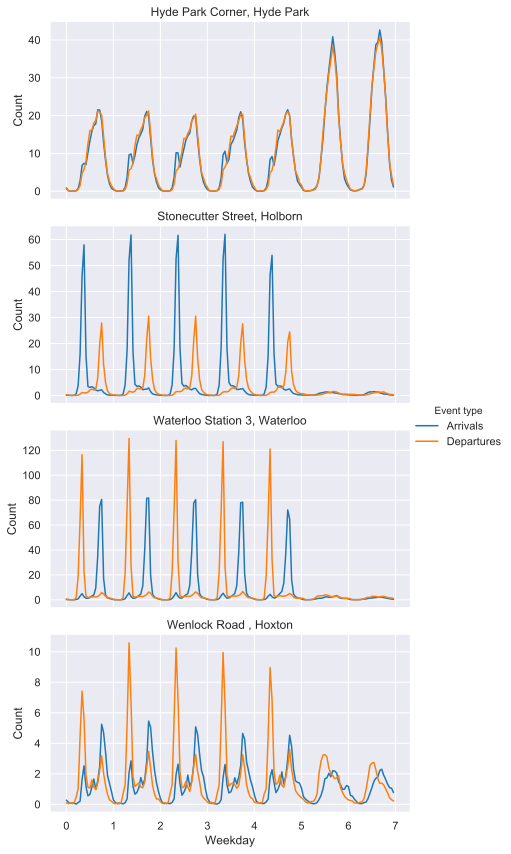

In [21]:
example_means_over_week = (
    events[example_stations].groupby([times.dt.weekday, times.dt.hour]).mean()
)
# Format the DataFrame into a format that seaborn likes.
example_means_over_week.index.rename(["Day", "Hour"], inplace=True)
example_means_over_week = (
    example_means_over_week.stack(level=[0, 1])
    .reset_index()
    .rename(columns={"level_3": "Event type", 0: "Count"})
)
example_means_over_week["Weekday"] = example_means_over_week.apply(
    lambda x: x["Day"] + x["Hour"] / 24, axis=1,
)
g = sns.FacetGrid(
    example_means_over_week,
    col_wrap=1,
    aspect=2,
    col="Station",
    hue="Event type",
    sharey=False,
    sharex=True,
)
g.map(plt.plot, "Weekday", "Count").set_titles("{col_name}")
g.add_legend();

The week starts from Monday in this plot.

The example stations here were deliberately picked to show different kinds of trends. Stonecutter Street and Waterloo are clearly commuter stations, that see action in the morning and the afternoon on weekdays. One is the end point of morning commutes, the other the start. Hyde Park Corner is very different, with popularity peaks being in the afternoon, and especially weekend afternoons. Wenlock Road is a bit of a mixture of these features, and gets much less traffic overall.

Let's do the same thing over a year instead of a week.

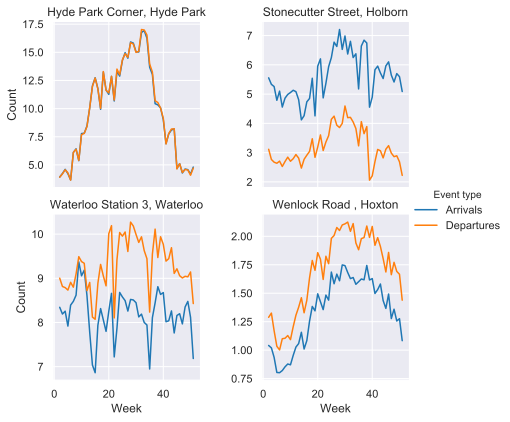

In [20]:
example_means_over_year = (
    events[example_stations].groupby(times.dt.week).mean()
)
# Leave out the first and last weeks, since they are usually shorter and thus
# the data isn't comparable.
example_means_over_year = example_means_over_year.iloc[1:51]
# Format to what seaborn likes.
example_means_over_year.index.rename("Week", inplace=True)
example_means_over_year = (
    example_means_over_year.stack(level=[0, 1])
    .reset_index()
    .rename(columns={"level_2": "Event type", 0: "Count"})
)
g = sns.FacetGrid(
    example_means_over_year,
    col_wrap=2,
    col="Station",
    hue="Event type",
    sharey=False,
    sharex=True,
)
g.map(plt.plot, "Week", "Count").set_titles("{col_name}")
g.add_legend();

Again, different profiles, with Waterloo and Stonecutter, the commuter stations, being more even over the year (note different vertical scales), and Hyde Park Corner showing a huge preference for summer cycling.

Finally, in addition to weekly and seasonal trends, the stations have different long term trends. Here are the yearly rolling averages over our whole data period.

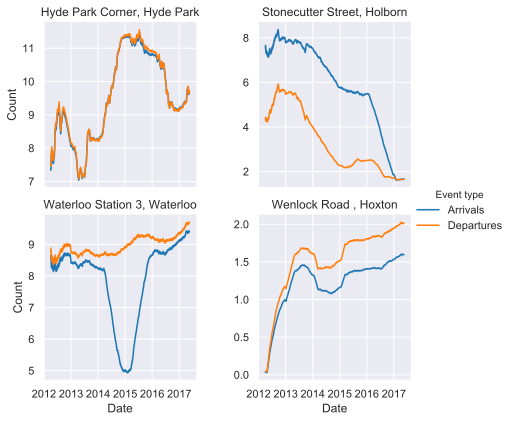

In [19]:
yearly_rolling = (
    events.loc[:, example_stations].rolling("365d", min_periods=24 * 90).mean()
)
yearly_rolling = (
    yearly_rolling.stack(level=[0, 1])
    .reset_index()
    .rename(columns={"level_2": "Event type", 0: "Count"})
)
g = sns.FacetGrid(
    yearly_rolling,
    col_wrap=2,
    col="Station",
    hue="Event type",
    sharey=False,
    sharex=True,
)
g.map(plt.plot, "Date", "Count").set_titles("{col_name}")
g.add_legend();

Some rising and falling trends, and for some reason a period of time when people stopped arriving at Waterloo Station with their Boris Bikes, but didn't stop departing from there.

## Cross-validation and choosing predictors

The point of the above exploratory plots was to get a feel for the kind of trends we can expect to see, and to illustrate the differences between stations. Now that I start doing modelling and prediction, I'll always fit all the models per station and event type. I call a pair like ("Waterloo Station 3, Waterloo", "Departures") a column, and so I'll be fitting to each column separately. We'll use some of the above example columns as our validation set.

Before we start doing predictions, we should decide on how success is measured, and set up a framework for measuring performance of models. I choose to use a type of cross-validation often done with time series data, sometimes known as rolling cross-validation. In it you divide the data into consecutive chunks, each of which acts as a test set. For each test set, you train the model on all the data you have from before that test set. This is like the usual kind of cross-validation, except we never train on data from the future of the test set, to not accidentally create wormholes and disrupt spacetime by having effects from the future affect our prediction.

To have the validation run in a reasonable time, I choose to predict half a year at a time, and only start predictions after two years of data has been accumulated, because otherwise there isn't much to train on.

Finally, we need to decide on an error metric. I choose to use the mean absolute error, aka MAE. Why MAE, and not mean squared error, MSE? Because a bike is a bike is a bike. If we predict that there will be 10 departures, and there are in fact 20, causing an error of 10 bikes, this is only 10 times worse than if we had predicted 19 and made an error of 1 bike. With MSE, this would be treated as being a 100 times worse, which just isn't fair: Imagining a case where our predicting model is used for deciding how many bikes should be kept at each station, one missing bike means one unhappy person, ten means ten, not a hundred. This is especially important when comparing predictions between different stations, some of which see much more traffic than others.

Below is a class that implements the above type of cross-validation. There's one class that does this for a single column of data, and another that uses the first one to do multiple columns at a time.

In [22]:
class RollingValidatorSingleColumn:
    """A class for doing rolling cross-validation for data from a single
    column.
    """

    def __init__(
        self, data, predictors, min_training_time, prediction_time,
    ):
        # Each validator keeps a dictionary of all the modelclasses it has
        # tested, and the results that it got.
        self.models = {}
        # A cv_batch is a cross-validation batch, consisting of a set of
        # training data, training predictors, test data, and test predictors.
        # We slice up the data given to as many batches as we can, given the
        # size of the test sets we want, and the minimum amount of data we need
        # for training set to make sense. We start the slicing from the end, so
        # even the shortest training set may be longer than the minimum
        # required.
        self.cv_batches = []
        first_time = data.index.min()
        last_time = data.index.max()
        test_end_time = last_time
        cutoff = test_end_time - prediction_time
        while cutoff > first_time + min_training_time:
            training_data = data[:cutoff]
            training_predictors = predictors[:cutoff]
            test_data = data[cutoff:test_end_time]
            test_predictors = predictors[cutoff:test_end_time]
            self.cv_batches.append(
                (
                    training_data,
                    training_predictors,
                    test_data,
                    test_predictors,
                )
            )
            test_end_time = cutoff
            cutoff = test_end_time - prediction_time
        msg = "Created a RollingValidator with {} cross-validation batches.".format(
            len(self.cv_batches)
        )
        print(msg)

    def test_modelclass(self, modelclass, print_progress=False):
        """Test a given modelclass with this RollingValidator. A modelclass
        should be class the instances of which have the methods `train` and
        `predict`. `train` in training data and training predictors, and
        predict takes in predictors and returns predictions.

        A separate instance of the model class is created for each
        cross-validation batch, trained and asked to predict on the test set.
        It is also asked to predict on the training set. Errors are computed
        for both. All predictions and errors are stored in
        self.models[modelclass]. The method returns the MAE over all the
        cross-validation batches.
        """
        # We collect the predictions and errors from different batches.
        test_errors = []
        training_errors = []
        test_predictions = []
        training_predictions = []
        for (i, cv_batch,) in enumerate(self.cv_batches):
            (
                training_data,
                training_predictors,
                test_data,
                test_predictors,
            ) = cv_batch
            if print_progress:
                print("Training for batch {}.".format(i))
            model = modelclass()
            model.train(
                training_data, training_predictors,
            )
            if print_progress:
                print("Predicting for batch {}.".format(i))
            test_prediction = model.predict(test_predictors)
            training_prediction = model.predict(training_predictors)
            test_error = test_prediction - test_data
            training_error = training_prediction - training_data
            test_errors.append(test_error)
            training_errors.append(training_error)
            test_predictions.append(test_prediction)
            training_predictions.append(training_prediction)
        test_mae = pd.concat(test_errors).abs().mean()
        training_mae = pd.concat(training_errors).abs().mean()
        self.models[modelclass] = {
            "test_mae": test_mae,
            "training_mae": training_mae,
            "test_errors": test_errors,
            "training_errors": training_errors,
            "test_predictions": test_predictions,
            "training_predictions": training_predictions,
        }
        return test_mae


class RollingValidator:
    """A class for doing rolling cross-validation for data from a multiple
    columns.  Each column is run individually, using
    RollingValidatorSingleColumn.
    """

    def __init__(
        self,
        data,
        common_predictors,
        specific_predictors,
        min_training_time,
        prediction_time,
    ):
        """Initialization of a multicolumn RollingValidator takes, in addition
        to data to fit to and predictors common to all stations, also an
        argument called `specific_predictors`. This one should be a dictionary
        or DataFrame with one entry/column for each column in data, that holds
        predictors specific to that column only. It can also be None, in which
        case only the common predictors are used.
        """
        self.models = {}
        self.subrvs = {}
        # Create a RollingValidatorSingleColumn for each column in data.
        for c in data.columns:
            data_c = pd.DataFrame(data[c])
            if specific_predictors is not None and c in specific_predictors:
                predictors_c = pd.concat(
                    [common_predictors, specific_predictors[c]], axis=1
                )
            else:
                predictors_c = common_predictors
            subrv = RollingValidatorSingleColumn(
                data_c, predictors_c, min_training_time, prediction_time
            )
            self.subrvs[c] = subrv

    def test_modelclass(self, modelclass, print_progress=False):
        """Test a given modelclass with this RollingValidator. This runs
        RollingValidatorSingleColumn.test_modelclass for each column
        individually, and collects the result to a single dictionary
        self.models. It returns the sum of the MAEs for each column.
        """
        for c, subrv in self.subrvs.items():
            if print_progress:
                print("Running RV on {}.".format(c))
            subrv.test_modelclass(modelclass, print_progress=print_progress)
        # Collect the results into DataFrames that have different columns for
        # the different columns in the original data.
        self.models[modelclass] = {}
        for k in ("test_mae", "training_mae"):
            self.models[modelclass][k] = pd.concat(
                [subrv.models[modelclass][k] for subrv in self.subrvs.values()]
            )
        # The next(iter( part just takes the first of the entries in .values().
        num_batches = len(next(iter(self.subrvs.values())).cv_batches)
        for k in (
            "test_errors",
            "training_errors",
            "test_predictions",
            "training_predictions",
        ):
            self.models[modelclass][k] = [
                pd.concat(
                    [
                        subrv.models[modelclass][k][i]
                        for subrv in self.subrvs.values()
                    ],
                    axis=1,
                )
                for i in range(num_batches)
            ]
        test_mae = self.models[modelclass]["test_mae"].sum()
        return test_mae

Now that we have a framework for cross-validating, and we know what we want to predict, what should we give our models as predictors? There are at least two kinds of predictors we could use: Seasonal and autoregressive. By seasonal I mean things like which weekday it is, and what time it is. By autoregressive I mean past values in the same column.

Let's talk about seasonal ones first. As we saw above, there are strong variations in bike usage by the hour and weekday, and some clear variation also over the year. We could encode this is several different ways. The weekdays, especially weekend vs Monday to Friday, are clearly very distinct, and since there aren't too many of them either, dummy encoding seems like a good idea: 7 predictor variables that are 1 or 0 depending on whether it's that day of the week or not. For the intraday and intrayear patterns, I try two different encodings, dummy encoding and trigonometric. In the first one, each hour of the day and each month of the year gets it's own dummy variable. We could also consider doing dummies for weeks of the year instead of months, but let's try to avoid getting a huge number of predictor variables, for performance reasons, and to avoid overfitting as well. For the trigonometric encoding I turn the hours of the day and weeks of the year into angles around a circle, and then create two predictor variables, the sine and the cosine of that angle. They create a simple but natural encoding of continuous cyclical variables, and combined together they don't favor any one part of the cycle over others.

In [23]:
# Create a DataFrame with all the dummy encoded predictors.
weekday_dummies = pd.get_dummies(times.dt.weekday_name)
month_dummies = pd.get_dummies(times.dt.month)
hour_dummies = pd.get_dummies(times.dt.hour)
hour_dummies = hour_dummies.rename(
    columns={c: "Hour {}".format(c) for c in hour_dummies.columns}
)
month_dummies = month_dummies.rename(
    columns={c: "Month {}".format(c) for c in month_dummies.columns}
)
predictors_dum = pd.concat(
    [month_dummies, hour_dummies, weekday_dummies,], axis=1,
)

# Create a DataFrame with weekdays dummy encoded, but weeks and hours
# trigonometricly encoded.
day_angles = 2 * np.pi * times.dt.hour / 24
day_trigonometrics = pd.DataFrame(
    {"Day sine": np.sin(day_angles), "Day cosine": np.cos(day_angles)}
)
year_angles = 2 * np.pi * times.dt.week / 52
year_trigonometrics = pd.DataFrame(
    {"Year sine": np.sin(year_angles), "Year cosine": np.cos(year_angles),}
)
predictors_trig = pd.concat(
    [weekday_dummies, day_trigonometrics, year_trigonometrics], axis=1,
)

Imagine you are tasked to be the human model predicting bike use. You've learned that for a given station, on Mondays in January at 9am you usually get around 50 people departing. But now for the past three weeks straight, you've seen much less customers than usually. You should probably adjust your estimates then.

This gets to the autoregressive features. You could come up with any number of these: a weekly rolling average, monthly rolling average, usage at the same time of the day for three previous days, etc. We shouldn't include everything though, to avoid overfitting. What I've found works quite well, is to simply give as a predictor the value from the same column exactly a week before. The intraweek patterns are the strongest, fastest moving patterns in the data, and also very reliable, and looking at the usage from exactly a week ago gives pretty good idea of what to expect this time. The only downside is that we have to discard the first week of data since we don't have preceding data for that, but we've got hundreds of weeks left still.

Finally, there are more than a thousand columns in our data, and I don't have the patience to run every model on all of them just to test it. Instead I pick three example columns as to be our validation set of columns, that represent different types of stations as seen in the above extrapolation plots: Waterloo to represent commuter-heavy stations, Hyde Park Corner to represent leisure rides, and Wenlock Road to represent a quieter station with a mix of users. This also gives us a natural way to separate validation from final testing: We'll do model selecting using these three columns, and then at the very end test performance using a different set of columns.

In [24]:
# Data from exactly a week before.
events_offset = events.shift(freq=pd.Timedelta("7d"))

In [25]:
# Discard the first week, so that all our predictors and data cover the same
# timespan.
first_time = events_offset.index.min()
last_time = events.index.max()
data = events.loc[first_time:last_time, :]
predictors_trig = predictors_trig.loc[first_time:last_time, :]
predictors_dum = predictors_dum.loc[first_time:last_time, :]
events_offset = events_offset.loc[first_time:last_time, :]
times = data.index.to_series()

In [26]:
test_columns = [
    ("Waterloo Station 3, Waterloo", "Departures"),
    ("Hyde Park Corner, Hyde Park", "Arrivals"),
    ("Wenlock Road , Hoxton", "Arrivals"),
]

With all that settled, I create to `RollingValidator` instances, `rv_trig` for the trigonometric encoding and `rv_dum` for the dummy encoding.

In [27]:
specific_predictors = events_offset[test_columns]
min_training_time = 2 * pd.Timedelta("365d")
prediction_time = 0.5 * pd.Timedelta("365d")
rv_trig = RollingValidator(
    data[test_columns],
    predictors_trig,
    specific_predictors,
    min_training_time,
    prediction_time,
)
rv_dum = RollingValidator(
    data[test_columns],
    predictors_dum,
    specific_predictors,
    min_training_time,
    prediction_time,
)

Created a RollingValidator with 6 cross-validation batches.
Created a RollingValidator with 6 cross-validation batches.
Created a RollingValidator with 6 cross-validation batches.
Created a RollingValidator with 6 cross-validation batches.
Created a RollingValidator with 6 cross-validation batches.
Created a RollingValidator with 6 cross-validation batches.


## Machine learning models

With validation set up, it's time to create our first models. To set a baseline, here two very simple ones: `SimpleMean` just takes the mean of all the event counts in the column in question, and predicts that usage at all times will just be that mean value. `LastWeek` always predicts that usage now will be exactly the same as a week ago. I run our `RollingValidator` on both.

In [18]:
class SimpleMean:
    def __init__(self):
        self.model = None

    def train(self, data, predictors):
        mean = pd.DataFrame(data.mean())
        self.model = mean

    def predict(self, predictors):
        mean = self.model
        index = predictors.index
        predictions = mean.T.apply(lambda x: [x[0]] * len(index)).set_index(
            index
        )
        return predictions

In [19]:
class LastWeek:
    def train(self, data, predictors):
        pass

    def predict(self, predictors):
        # TODO Fix relying on column order, it's hacky.
        predictions = pd.DataFrame(predictors.iloc[:, -1])
        return predictions

In [32]:
def get_class_name(cls):
    """A function that returns a nice and simple string for the name of
    a class defined in __main__.
    """
    s = str(cls)
    parts = s.split("__main__.")
    result = parts[-1][:-2]
    return result

In [21]:
for modelclass in [SimpleMean, LastWeek]:
    print(get_class_name(modelclass))
    err = rv_trig.test_modelclass(modelclass)
    print("MAE: {:.3f}".format(err))

SimpleMean
MAE: 25.581
LastWeek
MAE: 12.239


That gives an idea of what we should aim for. If we get a MAE of more than 25 then something's going badly wrong. If we are above 12 or so, we aren't doing anything especially smart, a simple same-as-last-week prediction is just as good. Below that, and you can start calling it some level of success.

Scikit-learn offers easy-to-use classes for a lot of different kinds of regression models, and they are wonderfully easy to swap between, so let's make use of that. Here's a class that can be subclassed to run practically any scikit-learn regressor.

Note here that we should think about data normalization a bit. Most of our predictors come normalized already: They are dummy variables, or sinusoidal functions in the range [-1,+1]. But the data from a week before does not, and this is an issue for some regressors. Below we normalize this predictor variable by just dividing by the standard deviation. It brings it into a range comparable with the other predictors, without losing the property that the data is inherently non-negative.

In [22]:
class GenericModel:
    # Regressor should be a function that returns a scikit-learn regressor.
    # Meant to be overriden by subclasses.
    regressor = None

    def __init__(self):
        self.model = None
        self.column_name = None
        self.stds = {}

    def _normalize_predictors_train(self, predictors):
        """Normalize given predictors. predictors shoud be a dataframe, and
        every column that has "Departures" or "Arrivals" in the name will be
        divided by its standard deviation.  This function is meant to be called
        before training the model, and we store the standard deviations, so
        that the same normalization can be applied to when doing prediction.
        """
        predictors = predictors.copy()
        self.stds = {}
        for c in predictors.columns:
            try:
                is_stationcolumn = "Departures" in c or "Arrivals" in c
            except TypeError:
                is_stationcolumn = False
            if is_stationcolumn:
                col = predictors[c]
                std = col.std()
                predictors[c] = col / std
                self.stds[c] = std
        return predictors

    def _normalize_predictors_predict(self, predictors):
        """Normalize the given predictors the same way they were normalized
        before training. Meant to be called before predicting.
        """
        predictors = predictors.copy()
        for c in predictors.columns:
            try:
                is_stationcolumn = "Departures" in c or "Arrivals" in c
            except TypeError:
                is_stationcolumn = False
            if is_stationcolumn:
                col = predictors[c]
                std = self.stds[c]
                predictors[c] = col / std
        return predictors

    def train(self, data, predictors):
        predictors = self._normalize_predictors_train(predictors)
        self.model = self.regressor()
        # Some regressors don't like singleton dimensions, so remove them.
        np_predictors = predictors.values
        np_data = data.values.squeeze()
        self.model.fit(np_predictors, np_data)
        self.column_name = data.columns[0]

    def predict(self, predictors):
        predictors = self._normalize_predictors_predict(predictors)
        predictions = self.model.predict(predictors)
        name = self.column_name
        index = predictors.index
        predictions = np.squeeze(predictions)
        predictions = pd.DataFrame({name: predictions}, index=index)
        return predictions

With the above, we construct a number of model classes using different regressors scikit-learn offers.

In [23]:
class Linear(GenericModel):
    regressor = linear_model.Ridge


class KNeighbors(GenericModel):
    regressor = lambda x: neighbors.KNeighborsRegressor(
        n_neighbors=5, weights="distance"
    )


class LinearSVR(GenericModel):
    regressor = lambda x: svm.LinearSVR(max_iter=5000)


class RbfSVR(GenericModel):
    regressor = lambda x: svm.SVR(kernel="rbf", cache_size=500)


class PolySVR(GenericModel):
    regressor = lambda x: svm.SVR(kernel="poly", cache_size=500)


class DecisionTree(GenericModel):
    regressor = lambda x: tree.DecisionTreeRegressor(
        criterion="mae", max_depth=8
    )

A regularized linear model, k-nearest-neighbors with k=5, three support vector machines with different kernel functions, and a decision tree with no more than 8 layers. Why these? No strong reason, but I've been testing out different regressors and these all offer something different from the others, run on our data in a reasonable amount of time, and produce decent results. I am not an expert on any of these (on the contrary I actually hadn't used anything other than linear regression before this project), and I haven't done any systematic hyperparameter tuning, so it's well possible that better results could be found with some different model or choice of parameters. We'll go with these for now though.

Here's a script that runs all the above models using both the trigonometric and the dummy encoding of predictors. This takes a good while, on my laptop a couple of hours. Since the Jupyter kernel has a habit of crashing and we don't want to rerun this, I store the results in two files in the current working directory, one for each predictor encoding.

In [24]:
classes = [
    SimpleMean,
    LastWeek,
    Linear,
    KNeighbors,
    LinearSVR,
    DecisionTree,
    RbfSVR,
    PolySVR,
]
for modelclass in classes:
    print(get_class_name(modelclass))
    for rv, rv_name in (
        (rv_trig, "Trigonometric encoding"),
        (rv_dum, "Dummy encoding"),
    ):
        start = timer()
        try:
            err = rv.test_modelclass(modelclass)
        except Exception as e:
            # We don't want to kill the whole script if something grows wrong
            # with one model, so just print the error and keep going.
            print(e)
        stop = timer()
        time = (stop - start) / 60
        print(
            "{:23} MAE: {:.3f}   (took {:.1f} mins)".format(rv_name, err, time)
        )
        with open("latest_rv_dum.p", "wb") as f:
            pickle.dump(rv_dum, f)
        with open("latest_rv_trig.p", "wb") as f:
            pickle.dump(rv_trig, f)
    print()

SimpleMean
Trigonometric encoding  MAE: 25.581   (took 0.0 mins)
Dummy encoding          MAE: 25.581   (took 0.0 mins)

LastWeek
Trigonometric encoding  MAE: 12.239   (took 0.0 mins)
Dummy encoding          MAE: 12.239   (took 0.0 mins)

Linear
Trigonometric encoding  MAE: 12.502   (took 0.0 mins)
Dummy encoding          MAE: 12.386   (took 0.0 mins)

KNeighbors
Trigonometric encoding  MAE: 11.335   (took 0.2 mins)
Dummy encoding          MAE: 11.547   (took 4.9 mins)

LinearSVR
Trigonometric encoding  MAE: 11.453   (took 0.1 mins)
Dummy encoding          MAE: 11.309   (took 0.1 mins)

DecisionTree
Trigonometric encoding  MAE: 10.633   (took 7.5 mins)
Dummy encoding          MAE: 11.083   (took 17.9 mins)

RbfSVR
Trigonometric encoding  MAE: 10.757   (took 17.2 mins)
Dummy encoding          MAE: 10.733   (took 35.4 mins)

PolySVR
Trigonometric encoding  MAE: 10.508   (took 17.2 mins)
Dummy encoding          MAE: 10.473   (took 40.7 mins)



In case you need it, here's how you load the results from the disk if your kernel dies.

In [25]:
with open("latest_rv_dum.p", "rb") as f:
    rv_dum = pickle.load(f)
with open("latest_rv_trig.p", "rb") as f:
    rv_trig = pickle.load(f)

The linear model does no better than our simple `LastWeek` thing, which isn't too surprising: For instance with the trigonometrically encoded variables, it can only ever fit sinusoidal patterns in the data. All the non-linear ones do better, but none by a huge margin. k-nearest-neighbors, which is essentially just a more sophisticad version of just predicting past values reoccurring, improves over `LastWeek` by an average of one bike per hour, as does linear SVR. The decision tree and SVRs with non-linear kernels improve somewhat on this still, but none get below a MAE of 10.5 or so.

The intuitive picture I draw from this is that beyond saying "this week will be like last week", there's only so much we can do to predict variations with the data we have. This little bit extra isn't too hard to get, several different choices of regressors and encodings can do it, but beyond that, we are still left with an average error of a bit more than 10 bikes per hour, that nothing I've tried is able to get rid of. Of course, there will be a hard bottom for how well our models can do, given that there are random fluctuations and external driving forces we have no way of predicting (road closure/vandalism of a station/a big shop opens nearby/etc.). Perhaps we are getting close to that limit.

To get a handle on how little or much our models are overfitting, here are, in addition to the test set MAEs, also the training set ones, when using dummy encoding.

In [26]:
print("{:25} Test     Training".format(""))
for modelclass, results in rv_dum.models.items():
    test_mae = results["test_mae"].sum()
    training_mae = results["training_mae"].sum()
    classname = get_class_name(modelclass)
    print("{:25} {:.3f}   {:.3f}".format(classname, test_mae, training_mae))

                          Test     Training
SimpleMean                25.581   24.211
LastWeek                  12.239   11.369
Linear                    12.386   11.760
KNeighbors                11.547   3.229
LinearSVR                 11.309   10.487
DecisionTree              11.083   9.534
RbfSVR                    10.733   9.335
PolySVR                   10.473   9.192


k-nearest-neighbors of course does anomalously well since it's not really doing any fitting at all, but other than that, nothing too surprising or worrying here.

Given that `LastWeek` already does almost as well as the fancier methods, one idea to try would be to apply all the above models to predicting differences in usage between now and a week ago, instead of predicting the usage directly. I tried this to some extent and found no great success. I suspect that when measuring variations instead of absolute values the yearly patterns for instance become quite hard to discern. Whatever the reason, it didn't work as well as I hoped.

To get a more intuitive feel for how our above models too, let's see what the predictions from the winner of our above comparison, PolyRBF on trigonometricly encoded predictors, look like. Here's a comparison between the predictions and the actual outcomes for the Hyde Park Corner station for one week in February 2017.

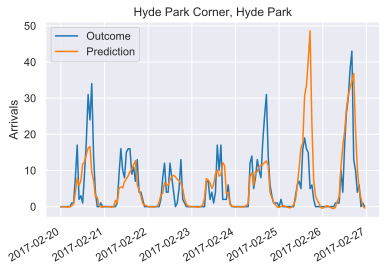

In [42]:
rv = rv_trig
timewindow = slice("2017-02-20", "2017-02-26")
plot_column = ("Hyde Park Corner, Hyde Park", "Arrivals")
# plot_columns = [("Wenlock Road , Hoxton", "Arrivals")]
# plot_columns = [("Waterloo Station 3, Waterloo",  "Departures")]
modelclass = PolySVR
err = pd.concat(rv.models[modelclass]["test_errors"]).sort_index()[timewindow]
pred = pd.concat(rv.models[modelclass]["test_predictions"]).sort_index()[
    timewindow
]
truth = data.loc[timewindow, plot_column]
plt.figure()
plt.plot(truth[plot_column], label="Outcome")
plt.plot(pred[plot_column], label="Prediction")
plt.ylabel(plot_column[1])
plt.title(plot_column[0])
plt.legend()
plt.gcf().autofmt_xdate()

## Poisson regression

So far we've been using generic machine learning methods that can be applied to any regression problem. But there's more about the structure of our data that we know, and haven't used yet. At any given time and for any given bike station, there's a rate at which people are coming to the station to take or return bikes. Furthermore, there's no reason to assume that one person's arrival would affect when the next one comes. (Unless, maybe, the station gets overcrowded, but let's ignore that possiblity.) This is exactly the kind of situation where the number of people arriving within a fixed time window should follow a Poisson distribution.

A Poisson distribution is defined by a single number, the rate at which events occur. That means that if you specify the its mean λ, you've specified everything there is to know about the distribution. Now of course the rate at which events occur, and thus λ, varies over time, but this gives an idea for a different, more principled way of modelling our data: assume that the data is Poisson-distributed, and try to fit a function that predicts its mean. This is called Poisson regression.

More specifically, we assume that the data follows a Poisson distribution, and that the _logarithm of the mean depends linearly on our predictors_. In statistics vocabulary, this is a generalized linear model with a Poisson distribution and a logarithmic link function. You may ask why specifically have a log-linear model for the mean. One reason is that its a simple and common enough choice that the fitting can be done with standard techniques that a good statistics package has implemented. Another is that due to how taking a logarithm turns multiplication into addition, what we are saying is that the mean should be a product of terms that depend on our predictors. This is more natural than saying it would be the sum (like what a linear regression model does), since for instance seasonal variation will likely increase or decrease bike usage by a fixed percentage, rather than a fix number of bikes.

The Python package statsmodels has some neat classes and methods of doing exactly this kind of Poisson regression. The optimization is implemented as a likelihood maximization. Here's a model class that uses statmodels Poisson regression, and can be fed to our cross-validator.

In [28]:
class PoissonGLM:
    def __init__(self):
        self.model = None
        self.column_name = None

    def train(self, data, predictors):
        glm_poisson = sm.GLM(data, predictors, family=sm.families.Poisson())
        model = glm_poisson.fit()
        self.model = model
        self.column_name = data.columns[0]

    def predict(self, predictors):
        name = self.column_name
        times = predictors.index.to_series()
        model = self.model
        predictions = model.predict(predictors)
        predictions = pd.DataFrame({name: predictions}, index=times)
        return predictions

Let's see how it performs. Due to the multiplicative nature of the log-linear fit, dummy variables are a much more natural encoding here than trigonometric functions, so I'll go with them.

In [29]:
modelclass = PoissonGLM
print(get_class_name(modelclass))
start = timer()
err = rv_dum.test_modelclass(modelclass)
stop = timer()
time = (stop - start) / 60
print("MAE: {:.3f}   (took {:.1f} mins)".format(err, time))

PoissonGLM
MAE: 11.441   (took 1.0 mins)


That's roughly as good as k-nearest-neighbors and a linear SVR, but not quite on the level of the non-linear SVRs. Poisson regression is much faster though (SVRs have a time complexity that scales as the square of the number of samples. I think Poisson regression is linear, but don't quote me on that), and more importantly much more interpretable and conceptually simple.

We can do better though. Given the complicated relationship between hours of the day and days of the week in our data set (for one, the bike trips are distributed more evenly over the day on weekends), it's clear that the log-linear model for the mean is overly simplistic. One simple way to go beyond it is to train multiple Poisson regressors, each of which deals with some subpart of the data set. For instance, we could fit one model take make predictions for weekends and another one for weekdays. The downside is that each regressor gets less training data, but luckily we have quite a lot to work with. Below is a generic implementation of a modelclass that groups the data according to some criterion, and trains a separate Poisson regressor for each group.

In [29]:
# There's an annoying detail to work around: The Poisson regressor from
# statmodels does not deal well with having data that is all or almost all
# zeros. I don't know exactly what goes wrong, but some sort of
# divergence/division-by-zero thing happens, and either the training function
# raises an error, or some of the predictions come out with values like
# 10,000,000 bikes. To work around this, I make a class that always predicts
# zero, and use that instead whenever the Poisson regressor seems to be
# misbehaving.


class ZeroPredictor:
    """A class that always predicts zeros."""

    def __init__(self, column_name):
        self.column_name = column_name

    def predict(self, predictors):
        column_name = self.column_name
        prediction = pd.DataFrame({column_name: 0.0}, index=predictors.index)
        return prediction


class PoissonGLMGrouped:
    """A class for doing Poisson regressors separately for different parts of
    the data. The method `gen_groupers` takes as an argument predictors, and
    outputs a DataFrame `groupers` that can be used as
    ``predictors.groupby(groupers)``
    ``data.groupby(groupers)``
    to split the predictors and data into groups, when training and
    predicting. A separate Poisson regressor is then trained and used for each
    group.
    
    In this class, `gen_groupers` is just None. This class is meant to be
    subclassed, and each subclass can then define its own gen_groupers.
    """

    gen_groupers = None

    def __init__(self):
        self.models = {}
        self.max = np.inf

    def train(self, data, predictors):
        self.models = {}
        # We keep track of the maximum value in the data, so that we know if
        # a prediction is entirely off the charts compared to it.
        self.max = data.max().max()

        groupers = self.gen_groupers(predictors)
        data_groups = data.groupby(groupers)
        predictors_groups = predictors.groupby(groupers)
        for group_label, data_group in data_groups:
            predictors_group = predictors_groups.get_group(group_label)
            try:
                model = PoissonGLM()
                model.train(data_group, predictors_group)
            except ValueError:
                # This happens if the data consists of mostly zeros, so just
                # return a model that always predicts zeros.
                model = ZeroPredictor(data.columns[0])
            self.models[group_label] = model

    def predict(self, predictors):
        groupers = self.gen_groupers(predictors)
        predictors_groups = predictors.groupby(groupers)
        predictions_groups = []
        for (group_label, predictors_group,) in predictors_groups:
            model = self.models[group_label]
            predictions_group = model.predict(predictors_group)
            # Check if some of the predictions are outrageously large compared
            # to any values in the training data. If so, assume that's a
            # malfunction, and set those predictions to zero.
            offthecharts = predictions_group > 10 * self.max
            predictions_group[offthecharts] = 0
            predictions_groups.append(predictions_group)
        predictions = pd.concat(predictions_groups, axis=0).sort_index()
        return predictions

I've tried a few variants of this, and having for instance separate weekend and weekday regressors is already a signifcant improvement, but the best results I've got have come out of training 24 Poisson regressors, one for each hour of the day. The coefficients of the log-linear model, that determine the effect of the other predictors, can then vary depending on the hour. Here's how it does:

In [30]:
def hours(self, predictors):
    times = predictors.index.to_series()
    hours = times.dt.hour
    return hours


class PoissonGLMHours(PoissonGLMGrouped):
    gen_groupers = hours

In [41]:
modelclass = PoissonGLMHours
print(get_class_name(modelclass))
start = timer()
err = rv_dum.test_modelclass(modelclass)
stop = timer()
time = (stop - start) / 60
print("MAE: {:.3f}   (took {:.1f} mins)".format(err, time))

PoissonGLMHours
MAE: 10.695   (took 0.3 mins)


That's more like it! This is very close to the best results we got with generic machine learning models, but runs in a fraction of the time, and is conceptually still far simpler and interpretable. This will be our model from now on.

## Weather 

One natural candidate for explaining some of the remaining variation that our model fails to capture is weather. Presumably a cold downpour would decrease the number of cyclists, and nice and sunny would increase it. Luckily, we have weather data for London at our disposal, so we can check whether that's true.

First let's load the weather data from a file, which has been downloaded from the [NOAA](https://www.ncdc.noaa.gov/cdo-web/search) website and is inlucded in the git repo. It has plenty of columns for minimum and maximum temperatures, snow depths (yeah, right) and whatnot, but many of them have more data missing than present. However, two are well-covered: Precipitation and daily average temperature.

In [34]:
wdf = pd.read_csv(
    "./data/weather/london_weather_data.csv",
    usecols=["DATE", "PRCP", "TAVG"],
    encoding="ISO-8859-2",
)
wdf["DATE"] = pd.to_datetime(wdf["DATE"])
wdf = wdf.set_index("DATE")

Let's restrict the data to our chosen time window, and fill the 6 missing precipitation data points as zeros.

In [35]:
wdf = wdf[first_time:last_time]
# There's only 6 NaNs in this time range, so how we fill them doesn't really
# matter much.
wdf["PRCP"] = wdf["PRCP"].fillna(0.0)

The weather data is on an daily basis, not hourly, which is too bad especially for the precipitation. We need to resample to an hourly frequency to match our bike data. For the temperature I interpolate with a second order polynomial, since it should vary smoothly. For precipitation I choose a linear interpretation instead. The values from the daily weather data are placed at noon, and the interpolation fills the gaps between noons.

In [36]:
wdf_resampled = wdf.resample("1h", loffset="12h").mean().reindex(times)
# The .bfill and .ffill fill the first and last half a day with the values of
# the first and last data point.
wdf_resampled["TAVG"] = (
    wdf_resampled["TAVG"]
    .interpolate(method="polynomial", order=2)
    .bfill()
    .ffill()
)
wdf_resampled["PRCP"] = (
    wdf_resampled["PRCP"].interpolate(method="linear").bfill().ffill()
)

To use this data as predictors, we normalize them to have variance one, and for the average temperature also a mean of zero.

In [37]:
wdfn = wdf_resampled.copy()
wdfn["PRCP"] /= wdfn["PRCP"].std()
wdfn["TAVG"] = (wdfn["TAVG"] - wdfn["TAVG"].mean()) / wdfn["TAVG"].std()

Time to see if adding the weather data as a predictor makes a difference.

In [38]:
predictors_dumw = pd.concat([predictors_dum, wdfn], axis=1)
rv_dumw = RollingValidator(
    data[test_columns],
    predictors_dumw,
    specific_predictors,
    min_training_time,
    prediction_time,
)

Created a RollingValidator with 6 cross-validation batches.
Created a RollingValidator with 6 cross-validation batches.
Created a RollingValidator with 6 cross-validation batches.


In [51]:
modelclass = PoissonGLMHours
print(get_class_name(modelclass))
start = timer()
err = rv_dumw.test_modelclass(modelclass)
stop = timer()
time = (stop - start) / 60
print("MAE: {:.3f}   (took {:.1f} mins)".format(err, time))

PoissonGLMHours
MAE: 10.560   (took 0.3 mins)


Yes, it does, but only a small one. Surprisinly so, if you ask me. The difference becomes much more drastic if you leave out the dummy variables for months of the year and then rerun with and without weather data, since much of the variation over the year is really variation due to average temperature. But I'm still surprised that having knowledge of exceptionally rainy or cold/warm days doesn't give us a bigger edge.

One nice feature of statistical models like Poisson regression, compared to generic machine learning methods, is that they provide superior interpretability, and allow things like statistical hypothesis testing. We can make use of that to find out whether weather really makes a difference for bike usage. To that end, I take two columns, departures from Waterloo (primarily a commuter station) and Hyde Park Corner (primarily a leisure station), fit a Poisson regression model to the whole time range, and print out the coefficients that the temperature and precipitation features get in the log-linear fit.

In [46]:
weather_test_columns = [
    ("Waterloo Station 3, Waterloo", "Departures"),
    ("Hyde Park Corner, Hyde Park", "Departures"),
]
alpha = 0.01  # The significance level.
for column in weather_test_columns:
    predictors = pd.concat([predictors_dumw, events_offset[column]], axis=1)
    glm_poisson = sm.GLM(
        data[column], predictors, family=sm.families.Poisson(),
    )
    print(column)
    model = glm_poisson.fit()
    lines = str(model.summary(alpha=alpha)).split("\n")
    for l in lines:
        # Print only the lines that concern precipitation or temperature,
        # plus the one header line that names the columns in the print.
        if "PRCP" in l or "TAVG" in l or "std err" in l:
            # Remove some excessive whitespace.
            l = l.replace("                   ", " ", 2)
            print(l)

('Waterloo Station 3, Waterloo', 'Departures')
                 coef    std err          z      P>|z|      [0.005      0.995]
PRCP          -0.0252      0.002    -15.891      0.000      -0.029      -0.021
TAVG           0.0489      0.003     16.549      0.000       0.041       0.056
('Hyde Park Corner, Hyde Park', 'Departures')
                coef    std err          z      P>|z|      [0.005      0.995]
PRCP         -0.0866      0.002    -50.055      0.000      -0.091      -0.082
TAVG          0.2853      0.003     96.175      0.000       0.278       0.293


Most interesting here are the confidence intervals on the right, that confirm that both precipitation and average temperature have a non-zero effect on bike usage with statistical signifcance at the 1% level, at the least. This is so even though our model includes as independent variables dummies for months of the year, which certainly are correlated with at least temperature. Note also that the effect is markedly larger for Hyde Park than for Waterloo, both with temperature and precipitation, as one would expect: Leisurely cyclists are more easily deterred by weather.

## Final test and conclusion

To wrap up, let's take our favourite model, Poisson regression with weather included, and do predictions on both the arrivals to and departures from a couple of stations we haven't looked at yet: Belgrove Street, King's Cross and Black Lion Gate, Kensington Gardens, both of which are among the busiest in town. Let's also do prediction in smaller chunks, 30 days at once, to hopefully increase accuracy. After all, if this was a real usage scenario, there would be no reason not to refit with the latest data every night.

In [45]:
test_stations = [
    "Belgrove Street , King's Cross",
    "Black Lion Gate, Kensington Gardens",
]
min_training_time = 2 * pd.Timedelta("365d")
prediction_time = pd.Timedelta("30d")
rv_test = RollingValidator(
    data[test_stations],
    predictors_dumw,
    events_offset[test_stations],
    min_training_time,
    prediction_time,
)
err = rv_test.test_modelclass(PoissonGLMHours)
print("MAE: {:.3f}".format(err))

Created a RollingValidator with 40 cross-validation batches.
Created a RollingValidator with 40 cross-validation batches.
Created a RollingValidator with 40 cross-validation batches.
Created a RollingValidator with 40 cross-validation batches.
MAE: 15.136


That mean absolute error can be contrasted with the average number of events per hour for the same stations, which is more than twice as large:

In [40]:
mean = data[test_stations].sum(axis=1).mean()
print("Mean: {:.3f}".format(mean))

Mean: 34.801


Here's an illustration of what our predictions are capable of, using as an example the same February week that we used before.

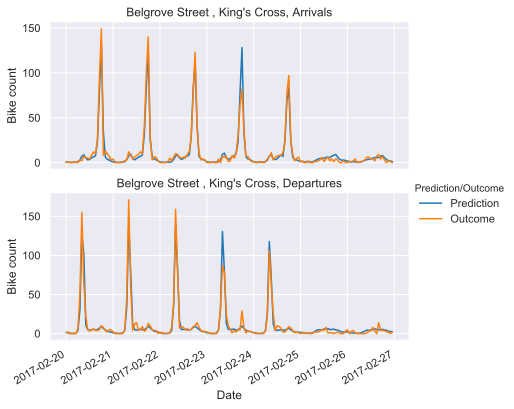

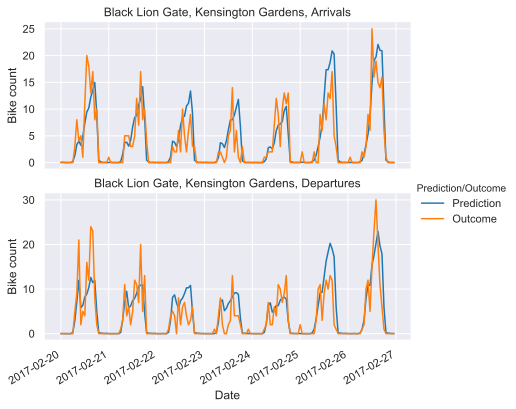

In [41]:
timewindow = slice("2017-02-20", "2017-02-26")
prediction = pd.concat(
    rv_test.models[PoissonGLMHours]["test_predictions"]
).sort_index()[timewindow]
outcome = data[test_stations].reindex(prediction.index)[timewindow]
outcome = (
    outcome.stack(level=[0, 1])
    .reset_index()
    .rename(columns={"level_2": "Event type", 0: "Outcome"})
)
prediction = (
    prediction.stack(level=[0, 1])
    .reset_index()
    .rename(
        columns={
            "level_1": "Station",
            "level_2": "Event type",
            0: "Prediction",
        }
    )
)
comparison = (
    pd.merge(prediction, outcome, on=["Date", "Station", "Event type"])
    .melt(id_vars=["Date", "Station", "Event type"])
    .rename(columns={"value": "Bike count", "variable": "Prediction/Outcome"})
)
for station in test_stations:
    plot_data = comparison[comparison["Station"] == station]
    g = sns.FacetGrid(
        plot_data,
        col_wrap=1,
        col="Event type",
        hue="Prediction/Outcome",
        aspect=2.0,
        sharey=False,
        sharex=True,
    )
    g.map(plt.plot, "Date", "Bike count").set_titles(station + ", {col_name}")
    g.add_legend()
    plt.gcf().autofmt_xdate()

Of course there are many additional things one could do to try to improve the predictions. The model selection process here has been very ad hoc and unsystematic, as was feature selection. I suspect that especially toying around with features, trying different combinations of autoregressive and seasonal predictors could be helpful. Overfitting hasn't been a huge a problem so far, so we could afford adding more predictors. We could also try to improve our Poisson regression model by going beyond the log-linear model for the mean, perhaps using a multilevel model. I'm especially tempted to try to make a Bayesian variant of the same idea, that would run in "real time" through the data set from start to finish, and update its coefficients as it progresses and gains new knowledge. We shall see whether I find the time to do that.

I hope you, my dear reader, have learned something about either Boris Bikes or time series regression through this project. I've certainly learned much: At the start of this project I had never used scikit-learn, didn't know what Poisson regression is, and hadn't ever really worked with statistical models and things like confidence intervals.

If you end up analysing the same data, building on what I've done hear, please let me know: [markus@mhauru.org](mailto:markus@mhauru.org)